<a href="https://colab.research.google.com/github/sgc-aiml/DC-GAN-using-TPU/blob/main/GAN_for_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the neccessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import distutils
import time

import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

import os
# import gdown
# from zipfile import ZipFile
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

# import glob
# import imageio
# import PIL

# from IPython import display

## Load the mnist data

In [2]:
fig_shape = (28,28,1)
(mnist_learn_images, mnist_learn_labels), (mnist_test_images,mnist_test_labels) = tf.keras.datasets.mnist.load_data()


mnist_images = np.concatenate((mnist_learn_images,mnist_test_images),axis = 0)
mnist_labels = np.concatenate((mnist_learn_labels,mnist_test_labels),axis = 0)  
#randomly mix the images 
index = np.arange(mnist_images.shape[0])
np.random.shuffle(index)

# the images are saved as X
# add a new axis for CNN
# normalize the images between -1 to 1
X = (mnist_images[index,:,:,np.newaxis] - 127.5) / 127.5

##if you are interested in labels too.. use this 
Y = mnist_labels[index]

plotting a random image of number: 7


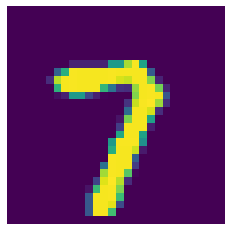

In [3]:
import random
pos = random.randint(0,mnist_images.shape[0])
plt.axis("off")
# print(x[0])
plt.imshow(np.reshape(X[pos],(28,28)))
print("plotting a random image of number: "+str(Y[pos]))


##Make models

### make generator

In [4]:
def make_generator(latent_dim=128):
  
  inputA = tf.keras.Input(shape=(latent_dim,))
  inputB = tf.keras.Input(shape=(10,))

  #gcomb = tf.keras.layers.Concatenate()([inputA,inputB])

  glayer = layers.Dense(7 * 7 * 128)(inputA)
  glayer = layers.Reshape((7, 7, 128))(glayer)
  glayer = layers.Conv2DTranspose(128, kernel_size=3, padding="same")(glayer)
  glayer = layers.LeakyReLU(alpha=0.2)(glayer)
  glayer = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(glayer)
  glayer = layers.LeakyReLU(alpha=0.2)(glayer)
  glayer = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(glayer)
  glayer = layers.LeakyReLU(alpha=0.2)(glayer)
  glayer = layers.Conv2D(1, kernel_size=5, padding="same", activation="tanh")(glayer)
  #generator = keras.models.Model(inputs=[inputA,inputB], outputs=glayer)
  generator = tf.keras.models.Model(inputs=inputA, outputs=glayer)  
  generator.summary()
  return generator

### make discriminator model



In [5]:
def make_discriminator(fig_shape=(28,28,1)):
  dinputA = tf.keras.Input(shape=fig_shape)
  dlayer = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(dinputA)
  dlayer = layers.LeakyReLU(alpha=0.2)(dlayer)

  dlayer = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(dlayer)
  dlayer = layers.LeakyReLU(alpha=0.2)(dlayer)

  # dlayer = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(dlayer)
  # dlayer = layers.LeakyReLU(alpha=0.2)(dlayer)
  
  dlayer = layers.Flatten()(dlayer)
  dlayer = layers.Dropout(0.2)(dlayer)

  dlayer = layers.Dense(2000)(dlayer)
  dlayer = layers.LeakyReLU(alpha=0.2)(dlayer)
  dlayer = layers.Dropout(0.2)(dlayer)

  dlayer3= layers.Dense(1, activation="sigmoid")(dlayer)
  

  discriminator = tf.keras.models.Model(inputs=dinputA, outputs=dlayer3)


  discriminator.summary()
  return discriminator

### define the losses

In [6]:
def discriminator_loss(real_output, fake_output,multiplier):
    
    #add random noise in the real label to improve the learning of GAN
    labels = tf.ones_like(real_output) - multiplier * tf.random.uniform(tf.shape(real_output))    
    
    real_loss = tf.nn.compute_average_loss(cross_entropy(labels, real_output), global_batch_size=GLOBAL_BATCH_SIZE)
    

    #add random noise in the fake label to improve the learning of GAN
    labels = tf.zeros_like(fake_output) + multiplier * tf.random.uniform(tf.shape(fake_output))
    
    fake_loss = tf.nn.compute_average_loss(cross_entropy(labels, fake_output), global_batch_size=GLOBAL_BATCH_SIZE)
    
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return tf.nn.compute_average_loss(cross_entropy(tf.ones_like(fake_output), fake_output), global_batch_size=GLOBAL_BATCH_SIZE)

    

### define the train_step

In [7]:
def train_step(inputs, multiplier=0.2):
    # images = images[0]
    images, labels = inputs
    BATCH_SIZE = len(images) # have same size of fake images as real images

    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = tf.clip_by_value(noise,clip_value_min=-2.0, clip_value_max=2.0)

  


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output,multiplier)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss,disc_loss)

    
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(6, 6, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

##Define the strategy

In [8]:
try:
  strategy == None
except:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  # optimizer = tf.tpu.CrossShardOptimizer(tf.train.GradientDescentOptimizer(0.01))

  strategy = tf.distribute.TPUStrategy(resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.58.114.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.58.114.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


###Define models and losses within strategy

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        147584    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                   

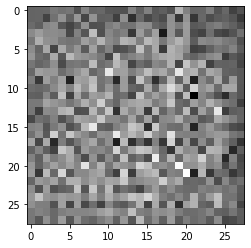

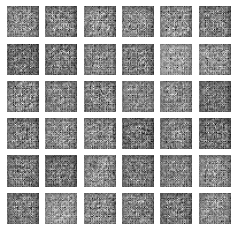

class values from decision model for the above picture is tf.Tensor(
[[0.5007571 ]
 [0.5007107 ]
 [0.5008259 ]
 [0.50072044]
 [0.5010949 ]
 [0.5009566 ]
 [0.5003567 ]
 [0.5007158 ]
 [0.5008555 ]
 [0.50080323]
 [0.500715  ]
 [0.500991  ]
 [0.50073403]
 [0.5005422 ]
 [0.5006004 ]
 [0.50055724]
 [0.50068015]
 [0.50080323]
 [0.5007864 ]
 [0.5008634 ]
 [0.5007361 ]
 [0.50075597]
 [0.500687  ]
 [0.5006316 ]
 [0.5006842 ]
 [0.50065583]
 [0.50117666]
 [0.5014667 ]
 [0.5008267 ]
 [0.50114447]
 [0.501133  ]
 [0.5006886 ]
 [0.500737  ]
 [0.50051737]
 [0.5006587 ]
 [0.5008702 ]], shape=(36, 1), dtype=float32)
models are made and ready to training


In [9]:
# feature_size = 44100
with strategy.scope():
  BUFFER_SIZE = 60000

  LATENT_COUNT = 100 

  EPOCHS = 300
  noise_dim = LATENT_COUNT
  num_examples_to_generate = 36

  BUFFER_SIZE = len(Y) #get the actual buffer size from label_data

  BATCH_SIZE_PER_REPLICA = 256
  GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
  BATCH_SIZE = GLOBAL_BATCH_SIZE

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE)
  

  # EPOCHS = 10

  # You will reuse this seed overtime (so it's easier)
  # to visualize progress in the animated GIF)
  # seed = tf.random.normal([num_examples_to_generate, noise_dim])


  noise = tf.random.normal([num_examples_to_generate, noise_dim])
  seed = tf.clip_by_value(noise,clip_value_min=-2.0, clip_value_max=2.0)

  #create the model and test them randomly
  generator = make_generator(LATENT_COUNT)
  discriminator = make_discriminator()

  generated_image = generator(seed, training=False)

  plt.imshow(generated_image[0, :, :, 0], cmap='gray')
  decision = discriminator(generated_image)
  generate_and_save_images(generator, 0, seed)
  print ("class values from decision model for the above picture is " + str(decision))  
  
  # Batch and shuffle the data
  train_dataset = tf.data.Dataset.from_tensor_slices((X,Y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

  #creating the loss functions
  cross_entropy = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)#.SUM_OVER_BATCH_SIZE#SUM
  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
  
print('models are made and ready to training')


##Train the data

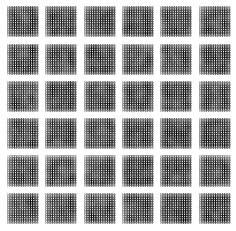

Epoch 1, Gen Loss: 0.0918545350432396, Disc Loss: 0.09759191423654556, time: 30.453532934188843


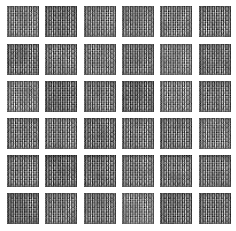

Epoch 2, Gen Loss: 0.2965799868106842, Disc Loss: 0.032650675624608994, time: 5.951177597045898


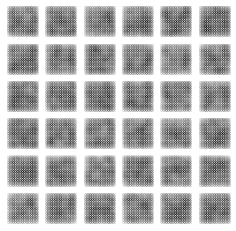

Epoch 3, Gen Loss: 0.217373788356781, Disc Loss: 0.03062126226723194, time: 7.423913240432739


In [ ]:
# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,0.0))
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                         axis=None)

time_history = np.zeros((EPOCHS,))
for epoch in range(EPOCHS):
  # TRAIN LOOP
  total_gen_loss = 0.0
  total_disc_loss = 0.0
  
  num_batches = 0
  start = time.time()
  for x in train_dist_dataset:
    (gen_loss,disc_loss) = distributed_train_step(x)
    total_gen_loss += gen_loss
    total_disc_loss += disc_loss
    
    num_batches += 1
  train_gen_loss = total_gen_loss / num_batches
  train_disc_loss = total_disc_loss / num_batches
  

  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                             epoch + 1,
                             seed)



  template = ("Epoch {}, Gen Loss: {}, Disc Loss: {}, time: {}")
  time_taken = time.time()-start
  print(template.format(epoch + 1, train_gen_loss, train_disc_loss, time_taken))
  time_history[epoch] = time_taken